Họ và tên:  Bùi Hoàng Phi  
MSSV:       2011799
# **Xử lí ảnh số và thị giác máy tính**
**Project 3: Gradient Domain Editing**

# Công thức

### Poisson Blending
Với s, t là giá trị điểm ảnh của ảnh nguồn (object/ source) và ảnh mục tiêu (target), ta có:
$$
v=\argmin_{v} \sum_{i\in S,\ j\in N_i\cap S} ((v_i - v_j) - (s_i - s_j))^2 + \sum_{i\in S,\ j\in N_i\cap S^c} ((v_i - t_j) - (s_i - s_j))^2
$$
Trong đó, i là một pixel trong nguồn $S$ và j là 4 pixel xung quanh i

# Hiện thực

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import os
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from typing import List, Tuple

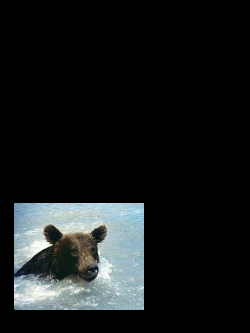

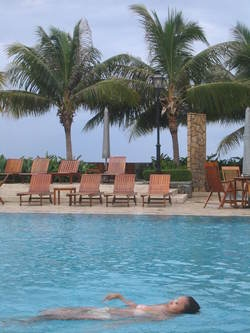

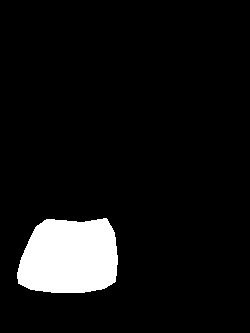

In [21]:
display(Image("object1.png", width=200))
display(Image("target1.jpg", width=200))
display(Image("object1_mask.png", width=200))

In [28]:
def get_image(img_path: str, mask: bool=False, scale: bool=True) -> np.array:
    if mask:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return np.where(binary_mask == 255, 1, 0)
    
    if scale:
        return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0
    
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

In [25]:
def neighbours(i: int, j: int, max_i: int, max_j: int) -> List[Tuple[int, int]]:
    pairs = []
    
    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))
    
    return pairs

In [26]:
#Gradient Domain Editing: Poisson Blending
def gradient_domain_editing(img_s: np.ndarray, mask: np.ndarray, img_t: np.ndarray):
    img_s_h, img_s_w = img_s.shape
    
    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)
    
    ys, xs = np.where(mask==1) 
        
    A = sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)
    
    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]  
        
        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            A[e, im2var[y][x]] = 1
            b[e] = img_s[y][x] - img_s[n_y][n_x]
            
            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1
    
    A = sparse.csr_matrix(A)
    v = linalg.lsqr(A, b)[0]
    
    img_t_out = img_t.copy()
    
    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]
    
    return np.clip(img_t_out, 0, 1)

# Kết quả

Kết quả thực thi đối với 2 bộ hình ảnh

input image shape: (333, 250, 3)


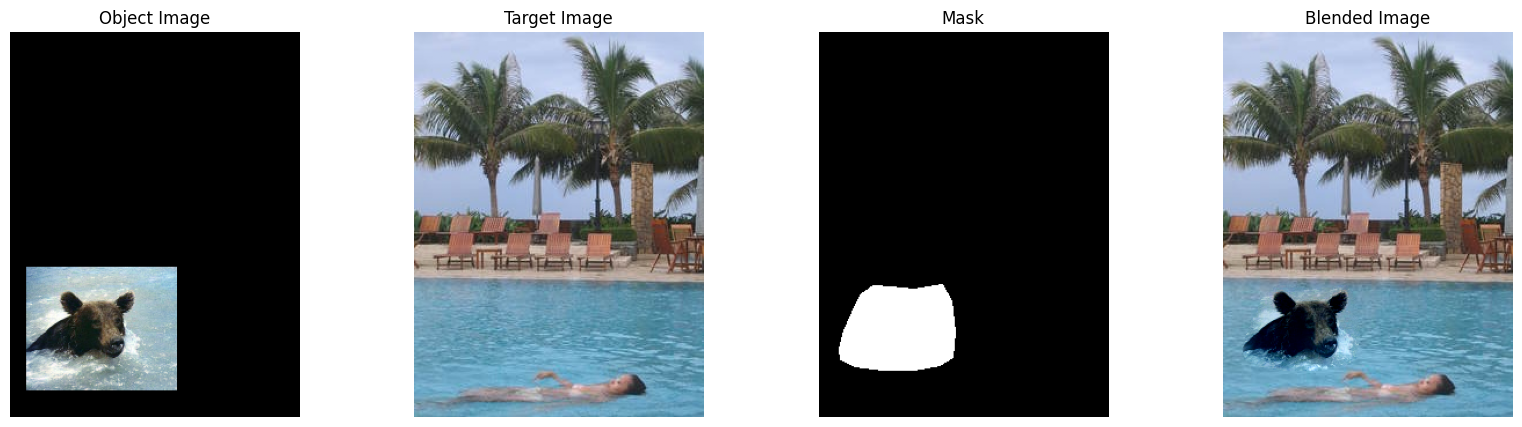

In [29]:
imgo1 = get_image("object1.png")
imgt1 = get_image("target1.jpg")
imgm1 = get_image("object1_mask.png", mask=True)

pixel_values = np.float32(imgo1)
print("input image shape: " + str(pixel_values.shape))

blend_img = np.zeros(imgt1.shape)
for b in np.arange(3):
    blend_img[:,:,b] = gradient_domain_editing(imgo1[:,:,b], imgm1, imgt1[:,:,b].copy())

#showing result
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(imgo1)
axs[0].set_title('Object Image')
axs[0].axis('off')
axs[1].imshow(imgt1)
axs[1].set_title('Target Image')
axs[1].axis('off')
axs[2].imshow(imgm1, cmap='gray')
axs[2].set_title('Mask')
axs[2].axis('off')
axs[3].imshow(blend_img)
axs[3].set_title('Blended Image')
axs[3].axis('off')
plt.show()

input image shape: (224, 259, 3)


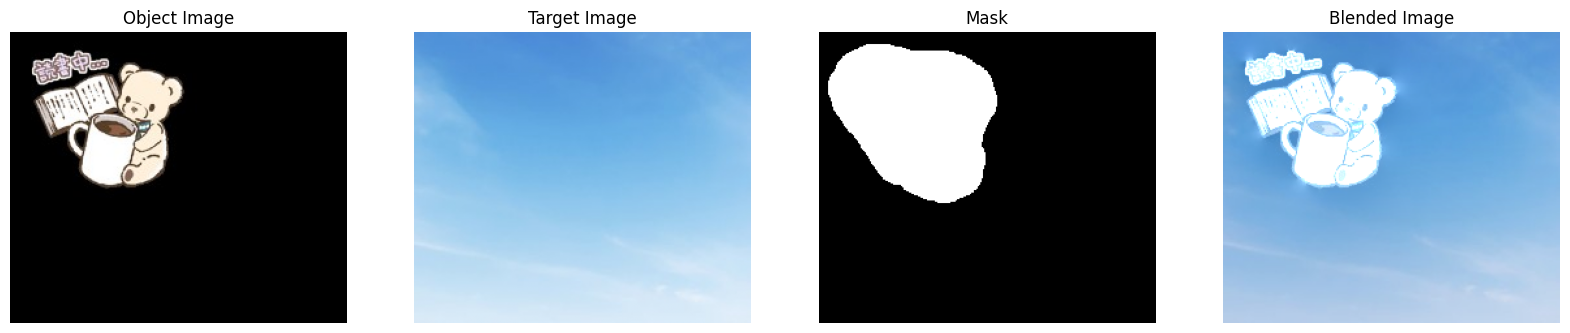

In [31]:
imgo2 = get_image("object2.jpg")
imgt2 = get_image("target2.jpg")
imgm2 = get_image("object2_mask.jpg", mask=True)

pixel_values = np.float32(imgo2)
print("input image shape: " + str(pixel_values.shape))

blend_img = np.zeros(imgt2.shape)
for b in np.arange(3):
    blend_img[:,:,b] = gradient_domain_editing(imgo2[:,:,b], imgm2, imgt2[:,:,b].copy())

#showing result
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(imgo2)
axs[0].set_title('Object Image')
axs[0].axis('off')
axs[1].imshow(imgt2)
axs[1].set_title('Target Image')
axs[1].axis('off')
axs[2].imshow(imgm2, cmap='gray')
axs[2].set_title('Mask')
axs[2].axis('off')
axs[3].imshow(img_blended)
axs[3].set_title('Blended Image')
axs[3].axis('off')
plt.show()

# Nhận xét, kết luận

## Nhận xét
- Khi thực hiện xử lí ảnh, tác vụ Blend thực hiện trộn một đối tượng trong một tấm ảnh nguồn vào một tấm ảnh khác.
- Với bài tập này, tôi sử dụng phương thức Poisson Blending. Kết quả cho thấy với ảnh và đối tượng có miền màu gần giống nhau, hình ảnh xuất ra có màu và sắc thái tương đối tự nhiên.

## Kết luận
- Với bài tập này, nhiệm vụ ghép đối tượng từ một hình vào một hình khác đã được hoàn thành. Hiện tại, quá trình thực hiện yêu cầu kích thước 3 tấm ảnh (ảnh nguồn, ảnh chứa thực thể, ảnh mask) cần giống nhau.
- Bài tập chưa hoàn thành việc kiểm tra với thực thể và ảnh làm nền có bộ màu tương phản hoặc gần tương phản. Quá trình thêm ảnh mask và chỉnh sửa ảnh chứa thực thể vẫn thực hiện thủ công bằng các ứng dụng chỉnh ảnh, chưa hoàn thiện chương trình để dễ dàng tạo ảnh thực thể và ảnh mask phục vụ kiểm tra.

# Repository

https://github.com/phii-1003/XLAS.git
(folder project3)